# Clustering!

This notebook picks up from 'Apta-MCTS-and0TN93-Exploration'. What we now have are pairwise interaction scores for each pair of aptamers in the set.
We’d like to get into clustering based on pairwise scores, and ideally selecting the aptamer in the cluster with the highest API score.

Thinking about clustering as I remember working with high-dimensional eg. RNAseq data, the general idea is to calculate pairwise distances in a high-dimensional "Euclidean" space, using the individual columns as dimensions.

These Tamura-Nei distances are essentially high-dimensional! The distance between a pair of nucleotide strings is calculated from the individual distances of the bases in each position. So, think of a 15 base sequence as being 15-dimensional.

So, we would cluster by replacing the "raw" input with the distance matrix.

Dr. Bell recommends:

1. Spectral
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html

2. dbScan
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

3. Agglomerative
(scipy.heirarchy.cluster)

In [ ]:
pip install tn93

In [ ]:
pip install Bio --q

In [ ]:
from tn93 import tn93 as model
from Bio import SeqIO
import pandas as pd
import statistics as stat

## The Tamura-Nei Function:

In [ ]:
def tamura_nei(s1,s2):
  #Make the SeqRecord objects for each.
  seq1 = SeqIO.SeqRecord(seq=s1)
  seq1.id=s1
  seq2 = SeqIO.SeqRecord(seq=s2)
  seq2.id=s2
  #And feed into the model.
  tn_model = model.TN93(minimum_overlap=8)
  distance = tn_model.tn93_distance(seq1, seq2, "RESOLVE")
  #The output looks like a list, but it isn't. Annoying.
  distance = distance.split(',')
  return(distance)

In [ ]:
tamura_nei('ATTATAGGTGATG','ATTAAAGGTGATG')

['ATTATAGGTGATG', 'ATTAAAGGTGATG', '0.0817849']

For independence, reimport the files as necessary: 'Exp_1_1.csv','Exp_2_1.csv', 'Exp_3_1.csv', 'Exp_4_1.csv', 'Exp_5_1.csv'

In [ ]:
#From StackExchange
from google.colab import files
def getLocalFiles():
    _files = files.upload()
    if len(_files) >0:
       for k,v in _files.items():
         open(k,'wb').write(v)
getLocalFiles()

Saving Exp_1_1.csv to Exp_1_1.csv
Saving Exp_1_16.csv to Exp_1_16.csv
Saving Exp_2_1.csv to Exp_2_1.csv
Saving Exp_2_16.csv to Exp_2_16.csv
Saving Exp_3_1.csv to Exp_3_1.csv
Saving Exp_3_16.csv to Exp_3_16.csv
Saving Exp_4_1.csv to Exp_4_1.csv
Saving Exp_4_16.csv to Exp_4_16.csv
Saving Exp_5_1.csv to Exp_5_1.csv
Saving Exp_5_16.csv to Exp_5_16.csv


## Define functions:

In [ ]:
def simple_count(entry, fin_output):
  flag = entry[1] in fin_output['primary_sequence'].values
  if flag == False:
    entry = list(entry)
    entry.append(1)
    fin_output.loc[len(fin_output.index)] = entry
  else:
    #Pandas doesn't seem to appreciate the user changing a singing value in an entry,
    #hence, the necessity of modifying and replacing the whole row.
    update = fin_output.loc[fin_output['primary_sequence'] == entry[1]]
    update = update.values[0]
    update[4] += 1
    fin_output.loc[fin_output['primary_sequence'] == entry[1]] = update
  return fin_output

In [ ]:
def csv_count(file, fin_output):
 inp = pd.read_csv(file, delimiter=',', encoding_errors = 'replace')
 inp = inp.values
 for entry in inp:
  #print (entry)
  #print()
  simple_count(entry,fin_output)
 return fin_output

In [ ]:
def mult_csv_count(file_list):
  if len(file_list)<2:
    print("It breaks if given less than two files. Please use 'csv_count'")
  #Reset input(every-time):
  fin_output = pd.DataFrame(columns=['aptamer_protein_interaction_score','primary_sequence','secondary_structure','minimum_free_energy', 'count'])
  for file in file_list:
    csv_count(file, fin_output)
  return fin_output

## Regenerate output:

In [ ]:
data = mult_csv_count(('Exp_1_1.csv','Exp_2_1.csv', 'Exp_3_1.csv', 'Exp_4_1.csv', 'Exp_5_1.csv'))
data

,aptamer_protein_interaction_score,primary_sequence,secondary_structure,minimum_free_energy,count
0,0.400000,AACCGGTTUAAAUAAUUUACGUUTTGGCCAA,....((((.((((.......)))).))))..,-3.4,1
1,0.400000,AACCGGTTAAUUAAUUUACGUGGTTGGCCAA,....(((((((((.......)))))))))..,-6.9,1
2,0.400000,AACCGGTTAAUAAUUUACGCUAATTGGCCAA,....(((((((...........)))))))..,-4.7,1
3,0.400000,AACCGGTTCAAAUAAUUUACGUUTTGGCCAA,....(((.((((..........)))))))..,-3.6,1
4,0.400000,AACCGGTTCUGUAAUUUACGUGGTTGGCCAA,(((((((..........)).)))))......,-2.9,1
...,...,...,...,...,...
495,0.371429,AACCGGTTCUAUAUGUGGUUGAGTTGGCCAA,..(((((((...........)))))))....,-3.5,1
496,0.371429,AACCGGTTAGUGUGGUUGUUAGCTTGGCCAA,....((((((.((........))))))))..,-5.6,1
497,0.371429,AACCGGTTAGUUUAAUGGUUGCUTTGGCCAA,....((((((.............))))))..,-3.6,1
498,0.371429,AACCGGTTCUGGUGGGUAAUUGUTTGGCCAA,.((((....))))((.(((....))).))..,-6.1,1


In [ ]:
o_seqs = data['primary_sequence'].values

In [ ]:
#For a pairwise comparison of *every* sequence:
l = []
for n in range(0, len(o_seqs)):
  for m in range(0, len(o_seqs)):
    try: #A few of the pairs return a 'math domain error'
      l.append(float(tamura_nei(o_seqs[n],o_seqs[m])[2]))
    except:
      pass
print('head:', l[0:5])
print('number of pairs:',len(l))
print('mean +/- stdev:', stat.mean(l), '+/-', stat.stdev(l))

head: [0.0, 0.536284, 0.495175, 0.0347229, 0.564295]
number of pairs: 249994
mean +/- stdev: 0.4718198465459171 +/- 0.13031145020222554


<Axes: ylabel='Count'>

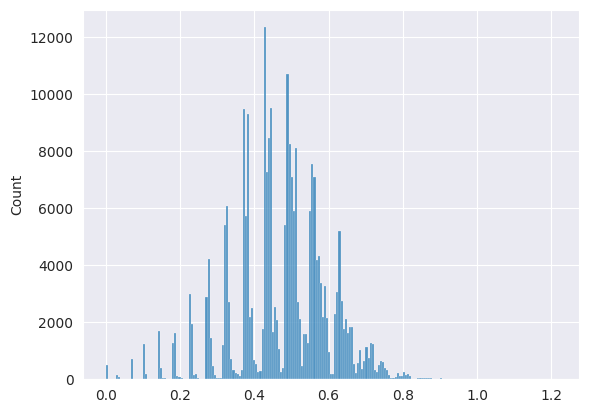

In [ ]:
sea.set_style('darkgrid')
sea.histplot(data=l)

In [ ]:
p = []
for _ in l:
  power = (1 - _)**3
  p.append(power)

print('head:', p[0:5])
print('number of pairs:',len(p))
print('mean +/- stdev:', stat.mean(p), '+/-', stat.stdev(p))

head: [1.0, 0.09971402405824571, 0.1286537832665157, 0.899406474654644, 0.08271373484302763]
number of pairs: 249994
mean +/- stdev: 0.17497192644603882 +/- 0.13357010842078712


<Axes: ylabel='Count'>

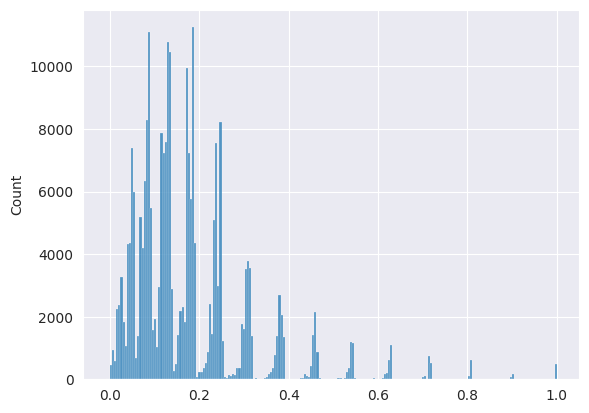

In [ ]:
sea.set_style('darkgrid')
sea.histplot(data=p)

All looks as before. Proceed to clustering.

### Clustering!

It asks for a distance matrix, and so I'll need to reformat my pairs as such. The good news is that they're already ordered implicitly. It requires a few tweaks to the pairwise code, to convert a list into a matrix.

In [ ]:
#For a pairwise comparison of *every* sequence:
dist_mat_tn = []
for n in range(0, len(o_seqs)):
  row = []
  for m in range(0, len(o_seqs)):
    try: #A few of the pairs return a 'math domain error'
      row.append(float(tamura_nei(o_seqs[n],o_seqs[m])[2]))
    except:
      print('Math_error', o_seqs[n],o_seqs[m])
      row.append(1.0)             #Impute the maximum distance.
  dist_mat_tn.append(row)

Math_error AACCGGTTAAGUGUGGUUUAUGATTGGCCAA AACCGGTTGGAAUUAAAUCGUAGTTGGCCAA
Math_error AACCGGTTAAGUGUUAAGGCUGGTTGGCCAA AACCGGTTGGACAGCCGAAGAAUTTGGCCAA
Math_error AACCGGTTGAUUAUAUUUAAAAATTGGCCAA AACCGGTTAGAUGUGGUUGUGGGTTGGCCAA
Math_error AACCGGTTGGAAUUAAAUCGUAGTTGGCCAA AACCGGTTAAGUGUGGUUUAUGATTGGCCAA
Math_error AACCGGTTGGACAGCCGAAGAAUTTGGCCAA AACCGGTTAAGUGUUAAGGCUGGTTGGCCAA
Math_error AACCGGTTAGAUGUGGUUGUGGGTTGGCCAA AACCGGTTGAUUAUAUUUAAAAATTGGCCAA


In [ ]:
distance_matrix = dist_mat_tn

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
dendrogram_file = 'scipy_dendrogram_file.pdf'

In [ ]:
#Labels:
o_seqs = list(o_seqs)

 Duplicate the basic dendrogram.

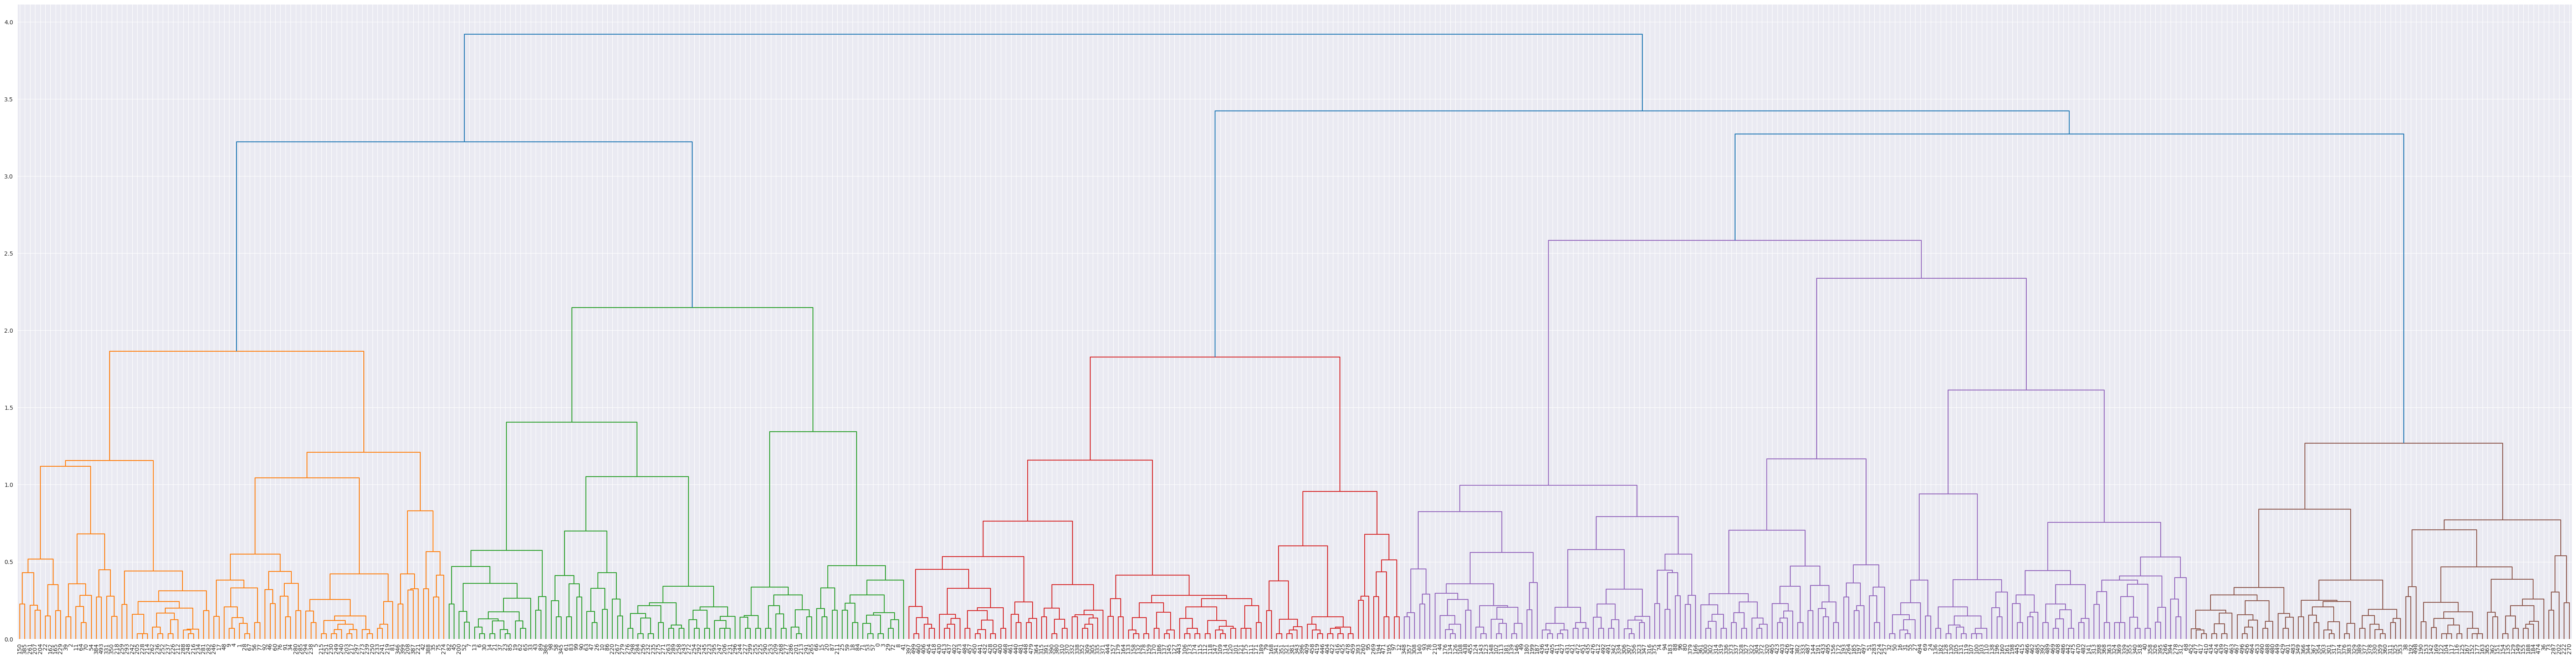

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

from scipy.spatial.distance import squareform

Z = linkage(squareform(distance_matrix), 'ward', optimal_ordering=True)

fig = plt.figure(figsize=(80,20))

dn = dendrogram(Z)

ax = plt.gca() #"Get current axes"

ax.tick_params(axis='x', which='major', labelsize=10)

plt.savefig(dendrogram_file,dpi=300)

plt.show()

plt.close()

#Dendrogram Results:

**To create a more descriptive dendrogram, I will: a. Flip the dendrogram 90 degrees. b. Replace number with the actual sequence: To create the desired labels, I'll also need to represent API-score, in order to look for visible correlation.**

In [ ]:
#Pull in all data.
seq_api = data
#Kill everything except for sequence and API score.
seq_api = seq_api.drop(['secondary_structure','minimum_free_energy','count'], axis=1)
#Convert from dataframe to array.
seq_api = seq_api.values
#Show a sample of the results:
print(seq_api[0:50:10])

#Ultimately needed as a dictionary.
seq_api_dict = {n[1]: n[0] for n in seq_api}
seq_api_dict['AACCGGTTUAAAUAAUUUACGUUTTGGCCAA']

[[0.4 'AACCGGTTUAAAUAAUUUACGUUTTGGCCAA']
 [0.3714285714285714 'AACCGGTTUCAAUUUACACUAAUTTGGCCAA']
 [0.3714285714285714 'AACCGGTTCUGGUAAUUUACAACTTGGCCAA']
 [0.3714285714285714 'AACCGGTTUAAAUUAAUUUACGCTTGGCCAA']
 [0.3428571428571428 'AACCGGTTGGUGUGAGGUCUGGCTTGGCCAA']]


0.4

In [ ]:
api_seq_str = []
for n in seq_api:
  record = n[1] + ' ' + str(round(n[0],2))
  if n[0] == 0.4:
    record+= ('0') #Nitpick
  api_seq_str.append(record)
api_seq_str[0:500:50]

['AACCGGTTUAAAUAAUUUACGUUTTGGCCAA 0.40',
 'AACCGGTTCGUAAUUAAUUUACGTTGGCCAA 0.34',
 'AACCGGTTAAGUUGUGGUUUAUGTTGGCCAA 0.49',
 'AACCGGTTGUUGGUUGCAGCAUGTTGGCCAA 0.40',
 'AACCGGTTAAGUUUAAAGUACGUTTGGCCAA 0.40',
 'AACCGGTTCCGUAAUUAAAUCGUTTGGCCAA 0.34',
 'AACCGGTTUGUUUUGAGGUUGGUTTGGCCAA 0.49',
 'AACCGGTTAAGGAUUGAGGUUGGTTGGCCAA 0.37',
 'AACCGGTTAAUUGUGGUUGUUUATTGGCCAA 0.49',
 'AACCGGTTAACUGUGGUUGUUAUTTGGCCAA 0.43']

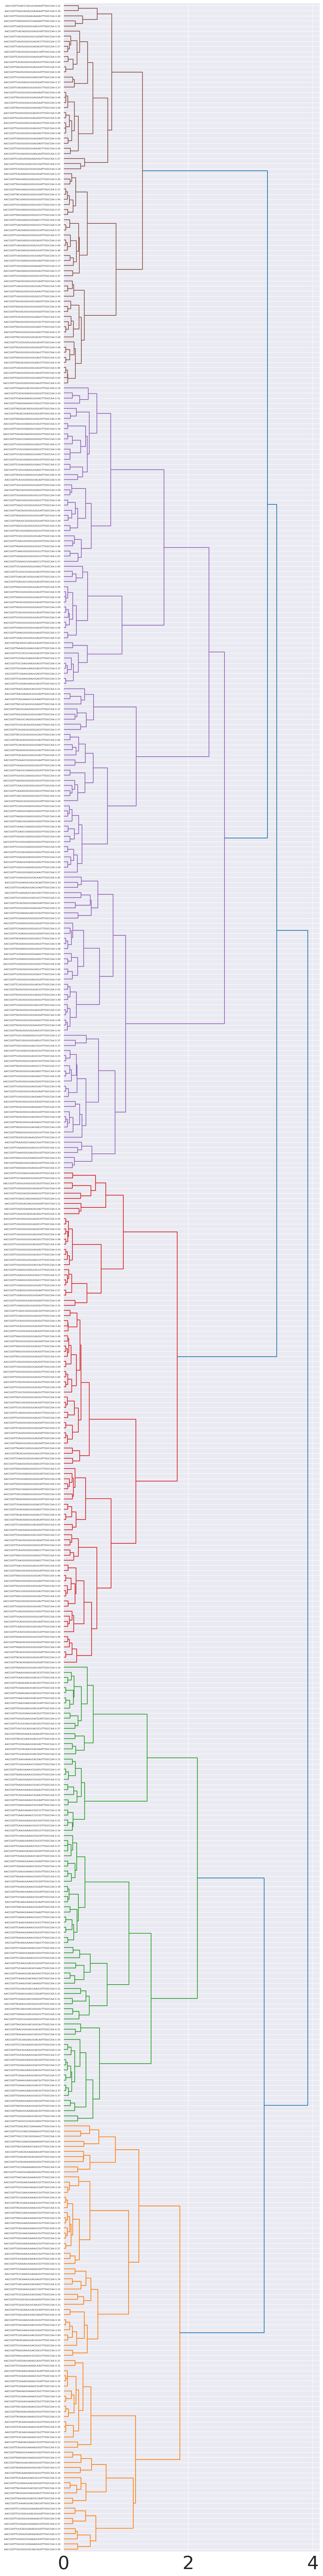

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

from scipy.spatial.distance import squareform

Z = linkage(squareform(distance_matrix), 'ward', optimal_ordering=True)

fig = plt.figure(figsize=(10,100))

dn = dendrogram(Z, labels = api_seq_str, orientation='right') ##https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html

ax = plt.gca() #"Get current axes"

ax.tick_params(axis='x', which='major', labelsize=40)

plt.savefig(dendrogram_file,dpi=300)

plt.show()

plt.close()

**Fascinating. In some groups, I'm seeing sequences which look like they have very little in common. In other groups, the clustering is clearly somewhat ordered. I think this could be even easier to interpret if I replaced the letters with colour-coded squares, like in a heatmap, and the the API scores with dots.**

**It is also clear to see that some groups contain "clumps" of very high API sequences, particularly the red group, here. Hence, proof that the API scores of related sequeces aare also often correlated, which is helpful.**

# Do the clusters correspond at all to the iterations of the program?

It may be that Apta-MCTS generates a family of related sequences each time you run it. If so, maybe it's possible to give it a "seed" sequence. Either way, that would be a very useful thing to know. To test this, I'll copy past everything I just did, editting the dendrogram to display iteration.

## Old Stuff:

(With a few modifications, to now display which file a sequence comes from.)

In [ ]:
pip install tn93

In [ ]:
pip install Bio --q

### Worked:

In [ ]:
import tn93

In [ ]:
dir(tn93)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'tn93']

Always look at the source-code (https://github.com/CDCgov/tn93/tree/main/src/tn93). Within the module tn93, there's a specific script called... tn93.

In [ ]:
from tn93 import tn93 as model

In [ ]:
from Bio import SeqIO

In [ ]:
def tamura_nei(s1,s2):
  #Make the SeqRecord objects for each.
  seq1 = SeqIO.SeqRecord(seq=s1)
  seq1.id=s1
  seq2 = SeqIO.SeqRecord(seq=s2)
  seq2.id=s2
  #And feed into the model.
  tn_model = model.TN93(minimum_overlap=8)
  distance = tn_model.tn93_distance(seq1, seq2, "RESOLVE")
  #The output looks like a list, but it isn't. Annoying.
  distance = distance.split(',')
  return(distance)

In [ ]:
tamura_nei('ATTATAGGTGATG','ATTAAAGGTGATG')

['ATTATAGGTGATG', 'ATTAAAGGTGATG', '0.0817849']

### Define functions:

In [ ]:
import pandas as pd

In [ ]:
def simple_count(entry, fin_output):
  flag = entry[1] in fin_output['primary_sequence'].values
  if flag == False:
    entry = list(entry)
    entry.append(1)
    fin_output.loc[len(fin_output.index)] = entry
  else:
    #Pandas doesn't seem to appreciate the user changing a singing value in an entry,
    #hence, the necessity of modifying and replacing the whole row.
    update = fin_output.loc[fin_output['primary_sequence'] == entry[1]]
    update = update.values[0]
    update[4] += 1
    fin_output.loc[fin_output['primary_sequence'] == entry[1]] = update
  return fin_output

In [ ]:
def csv_count(file, fin_output):
 inp = pd.read_csv(file, delimiter=',', encoding_errors = 'replace')
 inp = inp.values
 for entry in inp:
  #print (entry)
  #print()
  simple_count(entry,fin_output)
 return fin_output

In [ ]:
def mult_csv_count(file_list):
  if len(file_list)<2:
    print("It breaks if given less than two files. Please use 'csv_count'")
  #Reset input(every-time):
  fin_output = pd.DataFrame(columns=['aptamer_protein_interaction_score','primary_sequence','secondary_structure','minimum_free_energy', 'count'])
  for file in file_list:
    csv_count(file, fin_output)
  return fin_output

### It doesn't really work with the counting functions, but that's fine, given that there were no repeats anyway.

In [ ]:
fl = ['Exp_1_1.csv','Exp_2_1.csv', 'Exp_3_1.csv', 'Exp_4_1.csv', 'Exp_5_1.csv']
frames = []
for file in fl:
  name = file + 'df'
  name = pd.read_csv(file, delimiter=',', encoding_errors = 'replace')
  name['file'] = file

  frames.append(name)

fin_df = pd.concat(frames)
fin_df

,aptamer_protein_interaction_score,primary_sequence,secondary_structure,minimum_free_energy,file
0,0.400000,AACCGGTTUAAAUAAUUUACGUUTTGGCCAA,....((((.((((.......)))).))))..,-3.4,Exp_1_1.csv
1,0.400000,AACCGGTTAAUUAAUUUACGUGGTTGGCCAA,....(((((((((.......)))))))))..,-6.9,Exp_1_1.csv
2,0.400000,AACCGGTTAAUAAUUUACGCUAATTGGCCAA,....(((((((...........)))))))..,-4.7,Exp_1_1.csv
3,0.400000,AACCGGTTCAAAUAAUUUACGUUTTGGCCAA,....(((.((((..........)))))))..,-3.6,Exp_1_1.csv
4,0.400000,AACCGGTTCUGUAAUUUACGUGGTTGGCCAA,(((((((..........)).)))))......,-2.9,Exp_1_1.csv
...,...,...,...,...,...
95,0.371429,AACCGGTTCUAUAUGUGGUUGAGTTGGCCAA,..(((((((...........)))))))....,-3.5,Exp_5_1.csv
96,0.371429,AACCGGTTAGUGUGGUUGUUAGCTTGGCCAA,....((((((.((........))))))))..,-5.6,Exp_5_1.csv
97,0.371429,AACCGGTTAGUUUAAUGGUUGCUTTGGCCAA,....((((((.............))))))..,-3.6,Exp_5_1.csv
98,0.371429,AACCGGTTCUGGUGGGUAAUUGUTTGGCCAA,.((((....))))((.(((....))).))..,-6.1,Exp_5_1.csv


In [ ]:
fin_df

,aptamer_protein_interaction_score,primary_sequence,secondary_structure,minimum_free_energy,file
0,0.400000,AACCGGTTUAAAUAAUUUACGUUTTGGCCAA,....((((.((((.......)))).))))..,-3.4,Exp_1_1.csv
1,0.400000,AACCGGTTAAUUAAUUUACGUGGTTGGCCAA,....(((((((((.......)))))))))..,-6.9,Exp_1_1.csv
2,0.400000,AACCGGTTAAUAAUUUACGCUAATTGGCCAA,....(((((((...........)))))))..,-4.7,Exp_1_1.csv
3,0.400000,AACCGGTTCAAAUAAUUUACGUUTTGGCCAA,....(((.((((..........)))))))..,-3.6,Exp_1_1.csv
4,0.400000,AACCGGTTCUGUAAUUUACGUGGTTGGCCAA,(((((((..........)).)))))......,-2.9,Exp_1_1.csv
...,...,...,...,...,...
95,0.371429,AACCGGTTCUAUAUGUGGUUGAGTTGGCCAA,..(((((((...........)))))))....,-3.5,Exp_5_1.csv
96,0.371429,AACCGGTTAGUGUGGUUGUUAGCTTGGCCAA,....((((((.((........))))))))..,-5.6,Exp_5_1.csv
97,0.371429,AACCGGTTAGUUUAAUGGUUGCUTTGGCCAA,....((((((.............))))))..,-3.6,Exp_5_1.csv
98,0.371429,AACCGGTTCUGGUGGGUAAUUGUTTGGCCAA,.((((....))))((.(((....))).))..,-6.1,Exp_5_1.csv


### Regenerate output:

In [ ]:
#Plugging the results into the rest of the pipeline
data = fin_df
data

,aptamer_protein_interaction_score,primary_sequence,secondary_structure,minimum_free_energy,file
0,0.400000,AACCGGTTUAAAUAAUUUACGUUTTGGCCAA,....((((.((((.......)))).))))..,-3.4,Exp_1_1.csv
1,0.400000,AACCGGTTAAUUAAUUUACGUGGTTGGCCAA,....(((((((((.......)))))))))..,-6.9,Exp_1_1.csv
2,0.400000,AACCGGTTAAUAAUUUACGCUAATTGGCCAA,....(((((((...........)))))))..,-4.7,Exp_1_1.csv
3,0.400000,AACCGGTTCAAAUAAUUUACGUUTTGGCCAA,....(((.((((..........)))))))..,-3.6,Exp_1_1.csv
4,0.400000,AACCGGTTCUGUAAUUUACGUGGTTGGCCAA,(((((((..........)).)))))......,-2.9,Exp_1_1.csv
...,...,...,...,...,...
95,0.371429,AACCGGTTCUAUAUGUGGUUGAGTTGGCCAA,..(((((((...........)))))))....,-3.5,Exp_5_1.csv
96,0.371429,AACCGGTTAGUGUGGUUGUUAGCTTGGCCAA,....((((((.((........))))))))..,-5.6,Exp_5_1.csv
97,0.371429,AACCGGTTAGUUUAAUGGUUGCUTTGGCCAA,....((((((.............))))))..,-3.6,Exp_5_1.csv
98,0.371429,AACCGGTTCUGGUGGGUAAUUGUTTGGCCAA,.((((....))))((.(((....))).))..,-6.1,Exp_5_1.csv


In [ ]:
o_seqs = data['primary_sequence'].values
o_seqs

array(['AACCGGTTUAAAUAAUUUACGUUTTGGCCAA',
       'AACCGGTTAAUUAAUUUACGUGGTTGGCCAA',
       'AACCGGTTAAUAAUUUACGCUAATTGGCCAA',
       'AACCGGTTCAAAUAAUUUACGUUTTGGCCAA',
       'AACCGGTTCUGUAAUUUACGUGGTTGGCCAA',
       'AACCGGTTAGUAAAUUUAAUCGUTTGGCCAA',
       'AACCGGTTUUAAUUAAUUUACGCTTGGCCAA',
       'AACCGGTTAAAGUUAAUUUACGGTTGGCCAA',
       'AACCGGTTAAAUUAAUUUACGCGTTGGCCAA',
       'AACCGGTTAUGUAAUUUACGUGUTTGGCCAA',
       'AACCGGTTUCAAUUUACACUAAUTTGGCCAA',
       'AACCGGTTAUUUAUUUAUGGAUCTTGGCCAA',
       'AACCGGTTUCGCAAUUUAUGGUGTTGGCCAA',
       'AACCGGTTGGAAUUAAUUUACGCTTGGCCAA',
       'AACCGGTTUAAAUUAAUUUACGUTTGGCCAA',
       'AACCGGTTUUCAUAAUUUACAAATTGGCCAA',
       'AACCGGTTCCAAAUUAAUUUACGTTGGCCAA',
       'AACCGGTTAGUUAAUUUACGGCUTTGGCCAA',
       'AACCGGTTUGUGUAAUUUACGUATTGGCCAA',
       'AACCGGTTUUCAUUAAUUUACGGTTGGCCAA',
       'AACCGGTTCUGGUAAUUUACAACTTGGCCAA',
       'AACCGGTTCAAAUUAAUUUACGUTTGGCCAA',
       'AACCGGTTUUUAAUUUAAAAUCGTTGGCCAA',
       'AACCGGTTGUAAUUAAUUUACGUTTG

In [ ]:
import statistics as stat

### Clustering!

What we now have are pairwise interaction scores for each pair of aptamers in the set.
We’d like to get into clustering based on pairwise scores, and ideally selecting the aptamer in the cluster with the highest API score.

Thinking about clustering as I remember working with high-dimensional eg. RNAseq data, the general idea is to calculate pairwise distances in a high-dimensional "Euclidean" space, using the individual columns as dimensions.

These Tamura-Nei distances are essentially high-dimensional! The distance between a pair of nucleotide strings is calculated from the individual distances of the bases in each position. So, think of a 15 base sequence as being 15-dimensional.

So, we would cluster by replacing the "raw" input with the distance matrix.

Dr. Bell recommends:

1. Spectral
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html

2. dbScan
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

3. Agglomerative
(scipy.heirarchy.cluster)

#### Agglomerative:

It asks for a distance matrix, and so I'll need to reformat my pairs as such. The good news is that they're already ordered implicitly. It requires a few tweaks to the pairwise code, to convert a list into a matrix.

In [ ]:
#For a pairwise comparison of *every* sequence:
dist_mat_tn = []
for n in range(0, len(o_seqs)):
  row = []
  for m in range(0, len(o_seqs)):
    try: #A few of the pairs return a 'math domain error'
      row.append(float(tamura_nei(o_seqs[n],o_seqs[m])[2]))
    except:
      print('Math_error', o_seqs[n],o_seqs[m])
      row.append(1.0)             #Impute the maximum distance.
  dist_mat_tn.append(row)

Math_error AACCGGTTAAGUGUGGUUUAUGATTGGCCAA AACCGGTTGGAAUUAAAUCGUAGTTGGCCAA
Math_error AACCGGTTAAGUGUUAAGGCUGGTTGGCCAA AACCGGTTGGACAGCCGAAGAAUTTGGCCAA
Math_error AACCGGTTGAUUAUAUUUAAAAATTGGCCAA AACCGGTTAGAUGUGGUUGUGGGTTGGCCAA
Math_error AACCGGTTGGAAUUAAAUCGUAGTTGGCCAA AACCGGTTAAGUGUGGUUUAUGATTGGCCAA
Math_error AACCGGTTGGACAGCCGAAGAAUTTGGCCAA AACCGGTTAAGUGUUAAGGCUGGTTGGCCAA
Math_error AACCGGTTAGAUGUGGUUGUGGGTTGGCCAA AACCGGTTGAUUAUAUUUAAAAATTGGCCAA


In [ ]:
distance_matrix = dist_mat_tn

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
dendrogram_file = 'scipy_dendrogram_file.pdf'

In [ ]:
#Pull in all data.
seq_api = data
#Kill everything except for sequence and API score.  #But, leave 'file'!
seq_api = seq_api.drop(['secondary_structure','minimum_free_energy'], axis=1)
seq_api

,aptamer_protein_interaction_score,primary_sequence,file
0,0.400000,AACCGGTTUAAAUAAUUUACGUUTTGGCCAA,Exp_1_1.csv
1,0.400000,AACCGGTTAAUUAAUUUACGUGGTTGGCCAA,Exp_1_1.csv
2,0.400000,AACCGGTTAAUAAUUUACGCUAATTGGCCAA,Exp_1_1.csv
3,0.400000,AACCGGTTCAAAUAAUUUACGUUTTGGCCAA,Exp_1_1.csv
4,0.400000,AACCGGTTCUGUAAUUUACGUGGTTGGCCAA,Exp_1_1.csv
...,...,...,...
95,0.371429,AACCGGTTCUAUAUGUGGUUGAGTTGGCCAA,Exp_5_1.csv
96,0.371429,AACCGGTTAGUGUGGUUGUUAGCTTGGCCAA,Exp_5_1.csv
97,0.371429,AACCGGTTAGUUUAAUGGUUGCUTTGGCCAA,Exp_5_1.csv
98,0.371429,AACCGGTTCUGGUGGGUAAUUGUTTGGCCAA,Exp_5_1.csv


In [ ]:
#Convert from dataframe to array.
seq_api = seq_api.values
#Show a sample of the results:
print(seq_api[0:50:10])

#Ultimately needed as a dictionary.
seq_api_dict = {n[1]: n[0] for n in seq_api}
seq_api_dict['AACCGGTTUAAAUAAUUUACGUUTTGGCCAA']

[[0.4 'AACCGGTTUAAAUAAUUUACGUUTTGGCCAA' 'Exp_1_1.csv']
 [0.3714285714285714 'AACCGGTTUCAAUUUACACUAAUTTGGCCAA' 'Exp_1_1.csv']
 [0.3714285714285714 'AACCGGTTCUGGUAAUUUACAACTTGGCCAA' 'Exp_1_1.csv']
 [0.3714285714285714 'AACCGGTTUAAAUUAAUUUACGCTTGGCCAA' 'Exp_1_1.csv']
 [0.3428571428571428 'AACCGGTTGGUGUGAGGUCUGGCTTGGCCAA' 'Exp_1_1.csv']]


0.4

In [ ]:
len(seq_api)

500

In [ ]:
api_seq_str = []
for n in seq_api:
  record = n[1] + ' ' + str(round(n[0],2))
  if n[0] == 0.4:
    record+= ('0') #Nitpick
  api_seq_str.append(record)
api_seq_str[0:500:50]

['AACCGGTTUAAAUAAUUUACGUUTTGGCCAA 0.40',
 'AACCGGTTCGUAAUUAAUUUACGTTGGCCAA 0.34',
 'AACCGGTTAAGUUGUGGUUUAUGTTGGCCAA 0.49',
 'AACCGGTTGUUGGUUGCAGCAUGTTGGCCAA 0.40',
 'AACCGGTTAAGUUUAAAGUACGUTTGGCCAA 0.40',
 'AACCGGTTCCGUAAUUAAAUCGUTTGGCCAA 0.34',
 'AACCGGTTUGUUUUGAGGUUGGUTTGGCCAA 0.49',
 'AACCGGTTAAGGAUUGAGGUUGGTTGGCCAA 0.37',
 'AACCGGTTAAUUGUGGUUGUUUATTGGCCAA 0.49',
 'AACCGGTTAACUGUGGUUGUUAUTTGGCCAA 0.43']

In [ ]:
api_seq_file_str = []
for n in seq_api:
  record = n[2] + ' ' + n[1] + ' ' + str(round(n[0],2))
  if n[0] == 0.4:
    record+= ('0') #Nitpick
  api_seq_file_str.append(record)
api_seq_file_str[0:500:50]

['Exp_1_1.csv AACCGGTTUAAAUAAUUUACGUUTTGGCCAA 0.40',
 'Exp_1_1.csv AACCGGTTCGUAAUUAAUUUACGTTGGCCAA 0.34',
 'Exp_2_1.csv AACCGGTTAAGUUGUGGUUUAUGTTGGCCAA 0.49',
 'Exp_2_1.csv AACCGGTTGUUGGUUGCAGCAUGTTGGCCAA 0.40',
 'Exp_3_1.csv AACCGGTTAAGUUUAAAGUACGUTTGGCCAA 0.40',
 'Exp_3_1.csv AACCGGTTCCGUAAUUAAAUCGUTTGGCCAA 0.34',
 'Exp_4_1.csv AACCGGTTUGUUUUGAGGUUGGUTTGGCCAA 0.49',
 'Exp_4_1.csv AACCGGTTAAGGAUUGAGGUUGGTTGGCCAA 0.37',
 'Exp_5_1.csv AACCGGTTAAUUGUGGUUGUUUATTGGCCAA 0.49',
 'Exp_5_1.csv AACCGGTTAACUGUGGUUGUUAUTTGGCCAA 0.43']

#Finally, display the new dendrogram with new labels.

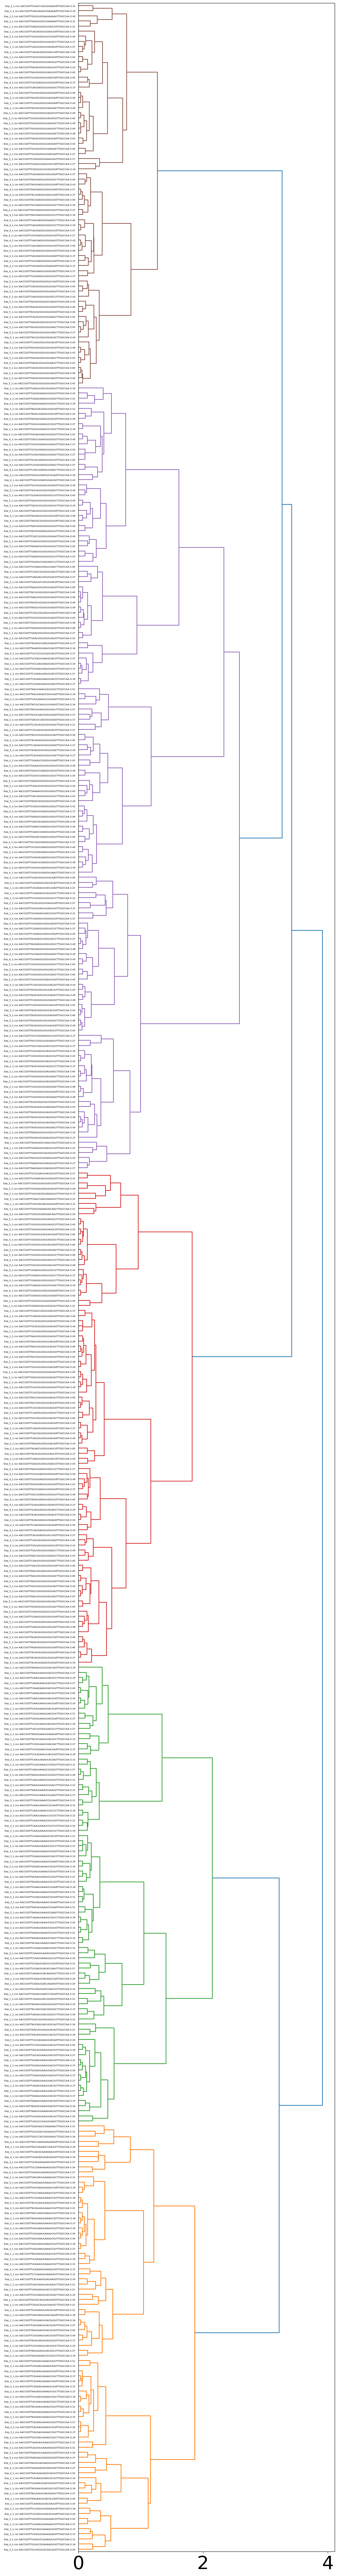

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

from scipy.spatial.distance import squareform

Z = linkage(squareform(distance_matrix), 'ward', optimal_ordering=True)

fig = plt.figure(figsize=(10,100))

dn = dendrogram(Z, labels = api_seq_file_str, orientation='right') ##https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html

ax = plt.gca() #"Get current axes"

ax.tick_params(axis='x', which='major', labelsize=40)

plt.savefig(dendrogram_file,dpi=300)

plt.show()

plt.close()

**The results are very cool. I see clustering, based on run, but with recurrence. That is, each time, the program seems to generate a few families of related candidate sequences. But! It may run into those families multiple times, on different rens of the program.**

#Scatter-Plot: Tamura-Nei distance vs Delta API-Score

If the "spread" decreases towards the lower end (this would be a scaterplot and a candlestick diagram), this would give evidence that sequences which are similar to eachother also interact with a protein in similar ways. This would bolster the idea that some of these sequences are redundant.

In [ ]:
import pandas as pd

In [ ]:
#From StackExchange
from google.colab import files
def getLocalFiles():
    _files = files.upload()
    if len(_files) >0:
       for k,v in _files.items():
         open(k,'wb').write(v)
getLocalFiles()

Saving Exp_1_1.csv to Exp_1_1 (1).csv
Saving Exp_1_16.csv to Exp_1_16 (1).csv
Saving Exp_2_1.csv to Exp_2_1 (1).csv
Saving Exp_2_16.csv to Exp_2_16 (1).csv
Saving Exp_3_1.csv to Exp_3_1 (1).csv
Saving Exp_3_16.csv to Exp_3_16 (1).csv
Saving Exp_4_1.csv to Exp_4_1 (1).csv
Saving Exp_4_16.csv to Exp_4_16 (1).csv
Saving Exp_5_1.csv to Exp_5_1 (1).csv
Saving Exp_5_16.csv to Exp_5_16 (1).csv


## Pipeline:

(I'm copying the whole thing each time, and then modifying as needed, in order to make each section of the analysis independent. -- To avoid having to disturb any previous sections each time I run the code.)

In [ ]:
pip install tn93

In [ ]:
pip install Bio --q

### Worked:

In [ ]:
import tn93

In [ ]:
dir(tn93)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'tn93']

Always look at the source-code (https://github.com/CDCgov/tn93/tree/main/src/tn93). Within the module tn93, there's a specific script called... tn93.

In [ ]:
from tn93 import tn93 as model

In [ ]:
from Bio import SeqIO

In [ ]:
def tamura_nei(s1,s2):
  #Make the SeqRecord objects for each.
  seq1 = SeqIO.SeqRecord(seq=s1)
  seq1.id=s1
  seq2 = SeqIO.SeqRecord(seq=s2)
  seq2.id=s2
  #And feed into the model.
  tn_model = model.TN93(minimum_overlap=8)
  distance = tn_model.tn93_distance(seq1, seq2, "RESOLVE")
  #The output looks like a list, but it isn't. Annoying.
  distance = distance.split(',')
  return(distance)

In [ ]:
tamura_nei('ATTATAGGTGATG','ATTAAAGGTGATG')

['ATTATAGGTGATG', 'ATTAAAGGTGATG', '0.0817849']

### As before, jam everything in a nice dataframe:

In [ ]:
fl = ['Exp_1_1.csv','Exp_2_1.csv', 'Exp_3_1.csv', 'Exp_4_1.csv', 'Exp_5_1.csv']
frames = []
for file in fl:
  name = file + 'df'
  name = pd.read_csv(file, delimiter=',', encoding_errors = 'replace')
  name['file'] = file

  frames.append(name)

fin_df = pd.concat(frames)
fin_df

,aptamer_protein_interaction_score,primary_sequence,secondary_structure,minimum_free_energy,file
0,0.400000,AACCGGTTUAAAUAAUUUACGUUTTGGCCAA,....((((.((((.......)))).))))..,-3.4,Exp_1_1.csv
1,0.400000,AACCGGTTAAUUAAUUUACGUGGTTGGCCAA,....(((((((((.......)))))))))..,-6.9,Exp_1_1.csv
2,0.400000,AACCGGTTAAUAAUUUACGCUAATTGGCCAA,....(((((((...........)))))))..,-4.7,Exp_1_1.csv
3,0.400000,AACCGGTTCAAAUAAUUUACGUUTTGGCCAA,....(((.((((..........)))))))..,-3.6,Exp_1_1.csv
4,0.400000,AACCGGTTCUGUAAUUUACGUGGTTGGCCAA,(((((((..........)).)))))......,-2.9,Exp_1_1.csv
...,...,...,...,...,...
95,0.371429,AACCGGTTCUAUAUGUGGUUGAGTTGGCCAA,..(((((((...........)))))))....,-3.5,Exp_5_1.csv
96,0.371429,AACCGGTTAGUGUGGUUGUUAGCTTGGCCAA,....((((((.((........))))))))..,-5.6,Exp_5_1.csv
97,0.371429,AACCGGTTAGUUUAAUGGUUGCUTTGGCCAA,....((((((.............))))))..,-3.6,Exp_5_1.csv
98,0.371429,AACCGGTTCUGGUGGGUAAUUGUTTGGCCAA,.((((....))))((.(((....))).))..,-6.1,Exp_5_1.csv


### Regenerate output:

In [ ]:
#Plugging the results into the rest of the pipeline
data = fin_df
data

,aptamer_protein_interaction_score,primary_sequence,secondary_structure,minimum_free_energy,file
0,0.400000,AACCGGTTUAAAUAAUUUACGUUTTGGCCAA,....((((.((((.......)))).))))..,-3.4,Exp_1_1.csv
1,0.400000,AACCGGTTAAUUAAUUUACGUGGTTGGCCAA,....(((((((((.......)))))))))..,-6.9,Exp_1_1.csv
2,0.400000,AACCGGTTAAUAAUUUACGCUAATTGGCCAA,....(((((((...........)))))))..,-4.7,Exp_1_1.csv
3,0.400000,AACCGGTTCAAAUAAUUUACGUUTTGGCCAA,....(((.((((..........)))))))..,-3.6,Exp_1_1.csv
4,0.400000,AACCGGTTCUGUAAUUUACGUGGTTGGCCAA,(((((((..........)).)))))......,-2.9,Exp_1_1.csv
...,...,...,...,...,...
95,0.371429,AACCGGTTCUAUAUGUGGUUGAGTTGGCCAA,..(((((((...........)))))))....,-3.5,Exp_5_1.csv
96,0.371429,AACCGGTTAGUGUGGUUGUUAGCTTGGCCAA,....((((((.((........))))))))..,-5.6,Exp_5_1.csv
97,0.371429,AACCGGTTAGUUUAAUGGUUGCUTTGGCCAA,....((((((.............))))))..,-3.6,Exp_5_1.csv
98,0.371429,AACCGGTTCUGGUGGGUAAUUGUTTGGCCAA,.((((....))))((.(((....))).))..,-6.1,Exp_5_1.csv


As to comparison here involves API-score, I need to include that in the list of input values. So, I modify 'o_seqs' to add it.

In [ ]:
o_seqs = data.drop(['secondary_structure', 'minimum_free_energy', 'file'],axis=1)
o_seqs = o_seqs.values
o_seqs



array([[0.4, 'AACCGGTTUAAAUAAUUUACGUUTTGGCCAA'],
       [0.4, 'AACCGGTTAAUUAAUUUACGUGGTTGGCCAA'],
       [0.4, 'AACCGGTTAAUAAUUUACGCUAATTGGCCAA'],
       [0.4, 'AACCGGTTCAAAUAAUUUACGUUTTGGCCAA'],
       [0.4, 'AACCGGTTCUGUAAUUUACGUGGTTGGCCAA'],
       [0.4, 'AACCGGTTAGUAAAUUUAAUCGUTTGGCCAA'],
       [0.3714285714285714, 'AACCGGTTUUAAUUAAUUUACGCTTGGCCAA'],
       [0.3714285714285714, 'AACCGGTTAAAGUUAAUUUACGGTTGGCCAA'],
       [0.3714285714285714, 'AACCGGTTAAAUUAAUUUACGCGTTGGCCAA'],
       [0.3714285714285714, 'AACCGGTTAUGUAAUUUACGUGUTTGGCCAA'],
       [0.3714285714285714, 'AACCGGTTUCAAUUUACACUAAUTTGGCCAA'],
       [0.3714285714285714, 'AACCGGTTAUUUAUUUAUGGAUCTTGGCCAA'],
       [0.3714285714285714, 'AACCGGTTUCGCAAUUUAUGGUGTTGGCCAA'],
       [0.3714285714285714, 'AACCGGTTGGAAUUAAUUUACGCTTGGCCAA'],
       [0.3714285714285714, 'AACCGGTTUAAAUUAAUUUACGUTTGGCCAA'],
       [0.3714285714285714, 'AACCGGTTUUCAUAAUUUACAAATTGGCCAA'],
       [0.3714285714285714, 'AACCGGTTCCAAAUUAAUUUACGTTGGCCAA'],
  

In [ ]:
import statistics as stat

### This workflow differs from the clustering work in that, first and foremost, what we need to work with is the pairwise Tamura-Nei distances, rather than a distance matrix.

In [ ]:
#For a pairwise comparison of *every* sequence:
pairwise_tn = []
for n in range(0, len(o_seqs)):
  for m in range(0, len(o_seqs)):
    try: #A few of the pairs return a 'math domain error'
      pairwise_tn.append([o_seqs[n][1],o_seqs[m][1],float(tamura_nei(o_seqs[n][1],o_seqs[m][1])[2])])
    except:
      print('Math_error', o_seqs[n][1],o_seqs[m][1])
      pairwise_tn.append([o_seqs[n][1],o_seqs[m][1], 1.0])    #Impute the maximum distance.

    #And now, we can add a block to generate the difference in API.



pairwise_tn

Math_error AACCGGTTAAGUGUGGUUUAUGATTGGCCAA AACCGGTTGGAAUUAAAUCGUAGTTGGCCAA
Math_error AACCGGTTAAGUGUUAAGGCUGGTTGGCCAA AACCGGTTGGACAGCCGAAGAAUTTGGCCAA
Math_error AACCGGTTGAUUAUAUUUAAAAATTGGCCAA AACCGGTTAGAUGUGGUUGUGGGTTGGCCAA
Math_error AACCGGTTGGAAUUAAAUCGUAGTTGGCCAA AACCGGTTAAGUGUGGUUUAUGATTGGCCAA
Math_error AACCGGTTGGACAGCCGAAGAAUTTGGCCAA AACCGGTTAAGUGUUAAGGCUGGTTGGCCAA
Math_error AACCGGTTAGAUGUGGUUGUGGGTTGGCCAA AACCGGTTGAUUAUAUUUAAAAATTGGCCAA


[['AACCGGTTUAAAUAAUUUACGUUTTGGCCAA', 'AACCGGTTUAAAUAAUUUACGUUTTGGCCAA', 0.0],
 ['AACCGGTTUAAAUAAUUUACGUUTTGGCCAA',
  'AACCGGTTAAUUAAUUUACGUGGTTGGCCAA',
  0.536284],
 ['AACCGGTTUAAAUAAUUUACGUUTTGGCCAA',
  'AACCGGTTAAUAAUUUACGCUAATTGGCCAA',
  0.495175],
 ['AACCGGTTUAAAUAAUUUACGUUTTGGCCAA',
  'AACCGGTTCAAAUAAUUUACGUUTTGGCCAA',
  0.0347229],
 ['AACCGGTTUAAAUAAUUUACGUUTTGGCCAA',
  'AACCGGTTCUGUAAUUUACGUGGTTGGCCAA',
  0.564295],
 ['AACCGGTTUAAAUAAUUUACGUUTTGGCCAA',
  'AACCGGTTAGUAAAUUUAAUCGUTTGGCCAA',
  0.372718],
 ['AACCGGTTUAAAUAAUUUACGUUTTGGCCAA',
  'AACCGGTTUUAAUUAAUUUACGCTTGGCCAA',
  0.325768],
 ['AACCGGTTUAAAUAAUUUACGUUTTGGCCAA',
  'AACCGGTTAAAGUUAAUUUACGGTTGGCCAA',
  0.380993],
 ['AACCGGTTUAAAUAAUUUACGUUTTGGCCAA',
  'AACCGGTTAAAUUAAUUUACGCGTTGGCCAA',
  0.143741],
 ['AACCGGTTUAAAUAAUUUACGUUTTGGCCAA',
  'AACCGGTTAUGUAAUUUACGUGUTTGGCCAA',
  0.514167],
 ['AACCGGTTUAAAUAAUUUACGUUTTGGCCAA',
  'AACCGGTTUCAAUUUACACUAAUTTGGCCAA',
  0.428225],
 ['AACCGGTTUAAAUAAUUUACGUUTTGGCCAA',
  'AACCGGTTAUU

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances
#For a pairwise comparison of *every* sequence:
pairwise_tn = []
for n in range(0, len(o_seqs)):
  for m in range(0, len(o_seqs)):
    block = []
    block.append([o_seqs[n][1],o_seqs[m][1]])
    try: #A few of the pairs return a 'math domain error'
      block.append(float(tamura_nei(o_seqs[n][1],o_seqs[m][1])[2]))
    except:
      print('Math_error', o_seqs[n][1],o_seqs[m][1])
      block.append(1.0)    #Impute the maximum distance.

    #And now, we can add a value to generate the difference in API.
    block.append(abs(o_seqs[n][0] - o_seqs[m][0]))

    pairwise_tn.append(block)



pairwise_tn

Math_error AACCGGTTAAGUGUGGUUUAUGATTGGCCAA AACCGGTTGGAAUUAAAUCGUAGTTGGCCAA
Math_error AACCGGTTAAGUGUUAAGGCUGGTTGGCCAA AACCGGTTGGACAGCCGAAGAAUTTGGCCAA
Math_error AACCGGTTGAUUAUAUUUAAAAATTGGCCAA AACCGGTTAGAUGUGGUUGUGGGTTGGCCAA
Math_error AACCGGTTGGAAUUAAAUCGUAGTTGGCCAA AACCGGTTAAGUGUGGUUUAUGATTGGCCAA
Math_error AACCGGTTGGACAGCCGAAGAAUTTGGCCAA AACCGGTTAAGUGUUAAGGCUGGTTGGCCAA
Math_error AACCGGTTAGAUGUGGUUGUGGGTTGGCCAA AACCGGTTGAUUAUAUUUAAAAATTGGCCAA


[[['AACCGGTTUAAAUAAUUUACGUUTTGGCCAA', 'AACCGGTTUAAAUAAUUUACGUUTTGGCCAA'],
  0.0,
  0.0],
 [['AACCGGTTUAAAUAAUUUACGUUTTGGCCAA', 'AACCGGTTAAUUAAUUUACGUGGTTGGCCAA'],
  0.536284,
  0.0],
 [['AACCGGTTUAAAUAAUUUACGUUTTGGCCAA', 'AACCGGTTAAUAAUUUACGCUAATTGGCCAA'],
  0.495175,
  0.0],
 [['AACCGGTTUAAAUAAUUUACGUUTTGGCCAA', 'AACCGGTTCAAAUAAUUUACGUUTTGGCCAA'],
  0.0347229,
  0.0],
 [['AACCGGTTUAAAUAAUUUACGUUTTGGCCAA', 'AACCGGTTCUGUAAUUUACGUGGTTGGCCAA'],
  0.564295,
  0.0],
 [['AACCGGTTUAAAUAAUUUACGUUTTGGCCAA', 'AACCGGTTAGUAAAUUUAAUCGUTTGGCCAA'],
  0.372718,
  0.0],
 [['AACCGGTTUAAAUAAUUUACGUUTTGGCCAA', 'AACCGGTTUUAAUUAAUUUACGCTTGGCCAA'],
  0.325768,
  0.028571428571428636],
 [['AACCGGTTUAAAUAAUUUACGUUTTGGCCAA', 'AACCGGTTAAAGUUAAUUUACGGTTGGCCAA'],
  0.380993,
  0.028571428571428636],
 [['AACCGGTTUAAAUAAUUUACGUUTTGGCCAA', 'AACCGGTTAAAUUAAUUUACGCGTTGGCCAA'],
  0.143741,
  0.028571428571428636],
 [['AACCGGTTUAAAUAAUUUACGUUTTGGCCAA', 'AACCGGTTAUGUAAUUUACGUGUTTGGCCAA'],
  0.514167,
  0.02857142857142863

In [ ]:
len(pairwise_tn)

250000

And finally we are really only interested in the second two columns, given that this is all going into a scatterplot of 25k points.

In [ ]:
pairwise_vals = []
for n in pairwise_tn:
  inp = []
  inp.append(float(n[1]))
  inp.append(float(n[2]))
  pairwise_vals.append(inp)

pairwise_vals

[[0.0, 0.0],
 [0.536284, 0.0],
 [0.495175, 0.0],
 [0.0347229, 0.0],
 [0.564295, 0.0],
 [0.372718, 0.0],
 [0.325768, 0.028571428571428636],
 [0.380993, 0.028571428571428636],
 [0.143741, 0.028571428571428636],
 [0.514167, 0.028571428571428636],
 [0.428225, 0.028571428571428636],
 [0.565668, 0.028571428571428636],
 [0.381391, 0.028571428571428636],
 [0.371475, 0.028571428571428636],
 [0.23187, 0.028571428571428636],
 [0.18554, 0.028571428571428636],
 [0.567237, 0.028571428571428636],
 [0.429416, 0.028571428571428636],
 [0.150049, 0.028571428571428636],
 [0.393413, 0.028571428571428636],
 [0.287993, 0.028571428571428636],
 [0.275071, 0.028571428571428636],
 [0.514868, 0.028571428571428636],
 [0.334298, 0.028571428571428636],
 [0.555729, 0.028571428571428636],
 [0.182691, 0.028571428571428636],
 [0.346635, 0.028571428571428636],
 [0.488392, 0.028571428571428636],
 [0.442532, 0.028571428571428636],
 [0.069116, 0.028571428571428636],
 [0.275071, 0.028571428571428636],
 [0.559103, 0.028571428

In [ ]:
print(len(pairwise_vals))
print(len(pairwise_vals[0]))

250000
2


In [ ]:
pairwise_val_mat = pd.DataFrame(pairwise_vals, columns = ['Tamura-Nei Distance', '(Delta)API-Score'])
pairwise_val_mat

,Tamura-Nei Distance,(Delta)API-Score
0,0.000000,0.0
1,0.536284,0.0
2,0.495175,0.0
3,0.034723,0.0
4,0.564295,0.0
...,...,...
249995,0.370783,0.0
249996,0.510667,0.0
249997,0.493008,0.0
249998,0.487932,0.0


<Axes: xlabel='Tamura-Nei Distance', ylabel='(Delta)API-Score'>

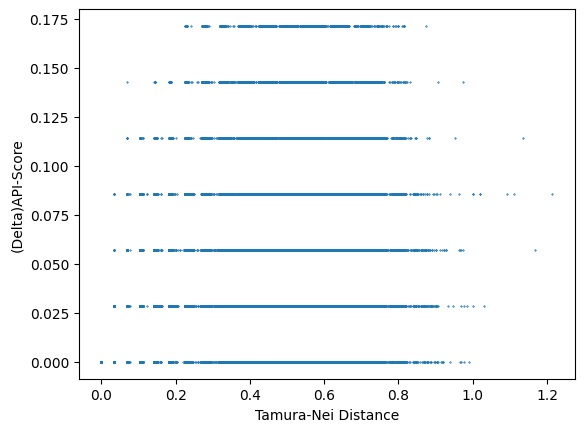

In [ ]:
DvAPI = pairwise_val_mat.plot.scatter(x='Tamura-Nei Distance', y='(Delta)API-Score', s=0.1)
DvAPI

Not quite what I was expecting to see. But, I do think that the trend show low Distances corresponding with lower mean API scores. I wasn't expecting them to be quantized like this, which makes the interpretation difficult.

An idea, create a subset that only correspends to T-N Distance of 0 - 0.2.

In [ ]:
pairwise_vals = []
for n in pairwise_tn:
  if float(n[1]) <0.21:
    inp = []
    inp.append(float(n[1]))
    inp.append(float(n[2]))
    pairwise_vals.append(inp)

pairwise_vals

In [ ]:
len(pairwise_vals)

8244

In [ ]:
pairwise_val_mat = pd.DataFrame(pairwise_vals, columns = ['Tamura-Nei Distance', '(Delta)API-Score'])
pairwise_val_mat

,Tamura-Nei Distance,(Delta)API-Score
0,0.000000,0.000000
1,0.034723,0.000000
2,0.143741,0.028571
3,0.185540,0.028571
4,0.150049,0.028571
...,...,...
8239,0.104788,0.057143
8240,0.033087,0.028571
8241,0.143510,0.028571
8242,0.184016,0.028571


## Output:

<Axes: xlabel='Tamura-Nei Distance', ylabel='(Delta)API-Score'>

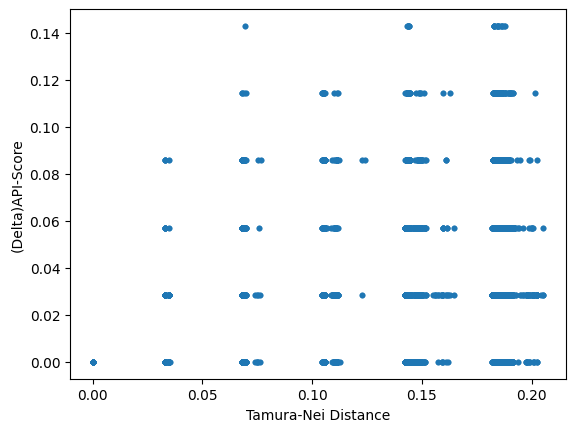

In [ ]:
DvAPI = pairwise_val_mat.plot.scatter(x='Tamura-Nei Distance', y='(Delta)API-Score', s=10)
DvAPI

Hmmm... I think this proves the point.

#Kill-Neighbors:

Logic: I've been operating on a particular guess, which I believe I've proven by now, that there are a number of "local minima". That is: a. Each time you run the program, it spits out a number (in this case, n = 100) of sequences which are not random, but are clusters of related sequences, whose binding affinities are also related to eachother. b. On sequential runs of the program, the groups produced "overlap", around the aforementioned clusters. -- Taken together, it is implied then, that there are one or more sequences in a cluster that will have the highest API-score in that cluster. Running the program more times, and gathering more sequences, makes it more-and-more likely that you'll hit that "local-minimum", or get close to it. So, generating more-and-more sequences, while killing off the sub-optimal sequences, should function as a sort of optimization problem. "How close do you want to get?"/"How likely do you want to be to get the optimal solution?" -> That depends on how many times you can afford to run Apta-MCTS, and the neighbor-killing function, which depends on your computing power.

Idelly, I'll be able to run Apta-MCTS directly in colab in the future, taking advantage of Google's runtime, and making it much simpler to iterate.

kill_neighbors(D=0.1, N=0)
- The function takes in a list of sequences, and their respective API scores.
- Function determines the number of neighbors a sequence has, based on 'D', the neighbourhood cutoff distance.
- The neighborhoods are then ranked by size.
- For the neighborhoods of the largest size, the sequence in that neighborhood with the lowest API score is "killed".

-Iterate the whole process until the largest neighborhood is of the maximum size, N.


I think it's time to move to new workbook.... https://colab.research.google.com/drive/1MsE9OS7SeNmVWXqzWuRXE44HL7hRqjEm#scrollTo=a0vMSMZMc50l